In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from PIL import Image
from sklearn.model_selection import train_test_split
import time
import random

import cv2

# Custom modules and packages
import params.learning
import uncertainty.functions
import uncertainty.evaluation
from utils import compute_mean_std
from dataset import TraversabilityDataset
from model import ResNet18Velocity
from train import train
from validate import validate
from test import test, test_models

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.learning.LEARNING

## Prepare data

#### Compute the mean and the standard deviation of the images set

In [3]:
# Load pre-computed mean and std
NORMALIZE_PARAMS = params.learning.NORMALIZE_PARAMS

normalize_params_recompute = False

if normalize_params_recompute:
    mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
    NORMALIZE_PARAMS = {"rbg": {"mean": mean[:3],
                                "std": std[:3]},
                        "depth": {"mean": mean[3],
                                  "std": std[3]},
                        "normal": {"mean": mean[4:],
                                   "std": std[4:]}}

print(NORMALIZE_PARAMS)

{'rbg': {'mean': tensor([0.4769, 0.5044, 0.4665]), 'std': tensor([0.1944, 0.1849, 0.1926])}, 'depth': {'mean': tensor([0.8172]), 'std': tensor([1.1132])}, 'normal': {'mean': tensor([-2.6290e-04,  4.0640e-01,  6.3510e-01]), 'std': tensor([0.3747, 0.4044, 0.2807])}}


In [4]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE),
    
    # Perform horizontal flip of the image with a probability of 0.5
    # transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(**params.learning.JITTER_PARAMS),
    
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

transform_depth = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["depth"]["mean"],
            std=NORMALIZE_PARAMS["depth"]["std"]
        ),
])

transform_normal = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["normal"]["mean"],
            std=NORMALIZE_PARAMS["normal"]["std"]
        ),
])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    transform_image=train_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_test.csv",
    images_directory=params.learning.DATASET+"images_test",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Set the train dataset size
train_size = params.learning.TRAIN_SIZE/(1-params.learning.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [5]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [6]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (11306 samples)
15.0 % of the data for validation (2423 samples)
15.0 % of the data for testing (2423 samples)


## GPU?

In [7]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [8]:
# Create a model
model = ResNet18Velocity(**params.learning.NET_PARAMS).to(device=device)

In [9]:
# Create dummy tensors
images = torch.randn(32,
                     params.learning.NET_PARAMS["nb_input_channels"],
                     params.learning.IMAGE_SHAPE[0],
                     params.learning.IMAGE_SHAPE[1]).to(device=device)  # (batch, channels, height, width)
data = torch.randn(32, 1).to(device=device)  # (batch, features)

print(model(images, data).shape)

torch.Size([32, 10])


#### Visualize the model

In [10]:
# Open TensorBoard
# tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
# images, traversal_costs, traversability_labels, linear_velocities = next(iter(train_loader))
# images = images.to(device)
# linear_velocities = linear_velocities.type(torch.float32).to(device)

# Add a dimension to the linear velocities tensor
# linear_velocities.unsqueeze_(1)

# tensorboard.add_graph(model, (images, linear_velocities))

print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
# print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

ResNet18Velocity(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [11]:
# Define the loss function (combines nn.LogSoftmax() and nn.NLLLoss())
criterion_classification = nn.CrossEntropyLoss()

# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Load the bins midpoints
bins_midpoints = np.load(params.learning.DATASET+"bins_midpoints.npy")
bins_midpoints = torch.tensor(bins_midpoints[:, None],
                              dtype=torch.float32,
                              device=device)

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
optimizer = optim.SGD([
    {"params": base_params},
    {"params": model.resnet18.fc.parameters(),
     "lr": LEARNING_PARAMS["learning_rate"]*10},
],
    lr=LEARNING_PARAMS["learning_rate"],
    momentum=LEARNING_PARAMS["momentum"],
    weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss and accuracy values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])
regression_loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy, train_regression_loss = train(model,
                                                              device,
                                                              train_loader,
                                                              optimizer,
                                                              criterion_classification,
                                                              criterion_regression,
                                                              bins_midpoints,
                                                              epoch)
    
    # Validation
    val_loss, val_accuracy, val_regression_loss = validate(model,
                                                           device,
                                                           val_loader,
                                                           criterion_classification,
                                                           criterion_regression,
                                                           bins_midpoints,
                                                           epoch) 
    
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy
    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss
    
#     # Add the losses to TensorBoard
#     tensorboard.add_scalar("train_loss", train_loss, epoch)
#     tensorboard.add_scalar("val_loss", val_loss, epoch)
#     # Add the accuracies to TensorBoard
#     tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
#     tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
#     # Add the regression losses to TensorBoard
#     tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
#     tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# # Close TensorBoard
# tensorboard.close()

  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  22.38634353440651
Validation accuracy:  27.610400330169213
Train regression loss:  1.2264395404165074
Validation regression loss:  0.9250179591931795


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  24.01379798337166
Validation accuracy:  25.91828312009905
Train regression loss:  1.037437896607286
Validation regression loss:  0.900900265888164


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  24.747921457633115
Validation accuracy:  27.156417664052828
Train regression loss:  1.0208072403056474
Validation regression loss:  0.8781734983387747


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  25.411286042809127
Validation accuracy:  30.293025175402395
Train regression loss:  1.0101046877897393
Validation regression loss:  0.8899230070804295


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  26.08349548912082
Validation accuracy:  23.400742880726373
Train regression loss:  0.9861930851208962
Validation regression loss:  0.8988579770452098


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  26.322306739784185
Validation accuracy:  31.035905901774658
Train regression loss:  0.9815979731284966
Validation regression loss:  0.8596294647768924


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  26.782239518839553
Validation accuracy:  28.93107717705324
Train regression loss:  0.9773616650178607
Validation regression loss:  0.8517302341367069


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  26.967981602688837
Validation accuracy:  28.02311184482047
Train regression loss:  0.9633690820912183
Validation regression loss:  0.8474003715734733


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  26.826463824517955
Validation accuracy:  27.692942633099463
Train regression loss:  0.9662392662238266
Validation regression loss:  0.8666960040205404


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  27.321776048116046
Validation accuracy:  31.20099050763516
Train regression loss:  0.9596089738405357
Validation regression loss:  0.8455486842676213


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  27.587121882186448
Validation accuracy:  31.159719356170037
Train regression loss:  0.9529392812716759
Validation regression loss:  0.8514595996392401


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  27.790553688307092
Validation accuracy:  27.280231118448206
Train regression loss:  0.9517495169141198
Validation regression loss:  0.879146375154194


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  27.587121882186448
Validation accuracy:  28.146925299215848
Train regression loss:  0.9487095600635992
Validation regression loss:  0.857599507036962


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  27.410224659472846
Validation accuracy:  27.280231118448206
Train regression loss:  0.9548586539629489
Validation regression loss:  0.8377762354518238


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  27.737484521493013
Validation accuracy:  30.912092447379283
Train regression loss:  0.9504301433509352
Validation regression loss:  0.8476093344782528


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  29.002299663895275
Validation accuracy:  28.93107717705324
Train regression loss:  0.9372445275891299
Validation regression loss:  0.8366751992388776


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  28.922695913674154
Validation accuracy:  27.40404457284358
Train regression loss:  0.9405307371148282
Validation regression loss:  0.8602918088436127


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  28.2327967450911
Validation accuracy:  30.540652084193148
Train regression loss:  0.9366877822384323
Validation regression loss:  0.8530251642591075


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  29.444542720679284
Validation accuracy:  29.797771357820885
Train regression loss:  0.9301033254902241
Validation regression loss:  0.839374030106946


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  29.18804174774456
Validation accuracy:  32.81056541477507
Train regression loss:  0.9369244306100963
Validation regression loss:  0.8328106564126516


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  28.53352202370423
Validation accuracy:  29.673957903425507
Train regression loss:  0.9339130768331431
Validation regression loss:  0.8420622901696908


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  30.14328675039802
Validation accuracy:  29.3437886917045
Train regression loss:  0.9249742692809994
Validation regression loss:  0.848558879996601


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  29.68335397134265
Validation accuracy:  30.499380932728023
Train regression loss:  0.9264046375529241
Validation regression loss:  0.830819446789591


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  29.55952591544313
Validation accuracy:  29.178704085843997
Train regression loss:  0.9179697140293607
Validation regression loss:  0.8431686657039743


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  29.745267999292412
Validation accuracy:  31.20099050763516
Train regression loss:  0.9162764678903892
Validation regression loss:  0.8340230631200891


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  30.65628869626747
Validation accuracy:  30.251754023937266
Train regression loss:  0.9154034507813427
Validation regression loss:  0.8337290447793508


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  29.798337166106492
Validation accuracy:  31.7375154766818
Train regression loss:  0.9111790105616305
Validation regression loss:  0.8316409964310495


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  31.036617725101717
Validation accuracy:  31.24226165910029
Train regression loss:  0.9161368189221721
Validation regression loss:  0.8299356218623487


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  31.319653281443482
Validation accuracy:  30.6231943871234
Train regression loss:  0.9081502095454157
Validation regression loss:  0.8370262568718508


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  31.76189633822749
Validation accuracy:  30.74700784151878
Train regression loss:  0.9049818329723541
Validation regression loss:  0.8256833674876314


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  31.514240226428445
Validation accuracy:  31.44861741642592
Train regression loss:  0.9003148299068381
Validation regression loss:  0.8439179176562711


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  31.018928002830357
Validation accuracy:  30.12794056954189
Train regression loss:  0.898458510553096
Validation regression loss:  0.836176156213409


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  32.071466477976294
Validation accuracy:  32.604209657449445
Train regression loss:  0.9049862405169482
Validation regression loss:  0.8388041924489172


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  32.75252078542367
Validation accuracy:  31.654973173751547
Train regression loss:  0.8931182031072465
Validation regression loss:  0.8292635271423742


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  32.54908897930302
Validation accuracy:  29.261246388774246
Train regression loss:  0.9023559948818832
Validation regression loss:  0.8589360788464546


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  32.575623562710064
Validation accuracy:  32.27404044572844
Train regression loss:  0.8966579079459616
Validation regression loss:  0.8182158003512182


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  34.09693967804706
Validation accuracy:  30.004127115146513
Train regression loss:  0.8940204530954361
Validation regression loss:  0.8403755061720547


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  33.539713426499205
Validation accuracy:  30.41683862979777
Train regression loss:  0.8837182897295656
Validation regression loss:  0.835933182584612


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  33.98195648328321
Validation accuracy:  31.035905901774658
Train regression loss:  0.8848681316032248
Validation regression loss:  0.8486680596282608


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  34.23845745621794
Validation accuracy:  27.486586875773835
Train regression loss:  0.8683368441580379
Validation regression loss:  0.8420714155623787


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  34.82221829117283
Validation accuracy:  31.985142385472553
Train regression loss:  0.8766016850700487
Validation regression loss:  0.8333297469898274


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  33.96426676101185
Validation accuracy:  30.33429632686752
Train regression loss:  0.865467929865344
Validation regression loss:  0.8423381177218336


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  35.44135857067044
Validation accuracy:  30.004127115146513
Train regression loss:  0.8596735350829733
Validation regression loss:  0.8467413602690947


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  35.689014682469484
Validation accuracy:  28.93107717705324
Train regression loss:  0.8676129818636146
Validation regression loss:  0.8744423056119367


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  36.219706350610295
Validation accuracy:  28.972348328518365
Train regression loss:  0.8582562557553167
Validation regression loss:  0.8862523256163848


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  36.73270829647974
Validation accuracy:  28.683450268262483
Train regression loss:  0.8499312546461989
Validation regression loss:  0.8595323844959861


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  36.22855121174597
Validation accuracy:  28.559636813867108
Train regression loss:  0.8564931128153019
Validation regression loss:  0.8876186915134129


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  37.06881301963559
Validation accuracy:  27.156417664052828
Train regression loss:  0.84680826776782
Validation regression loss:  0.8465999643269339


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  38.07712718910313
Validation accuracy:  31.283532810565415
Train regression loss:  0.8511620210220585
Validation regression loss:  0.8529813081810349


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

Train accuracy:  38.68742260746506
Validation accuracy:  29.797771357820885
Train regression loss:  0.8422266831674144
Validation regression loss:  0.8419961472483057


### Visualization

Text(0.5, 0, 'Epoch')

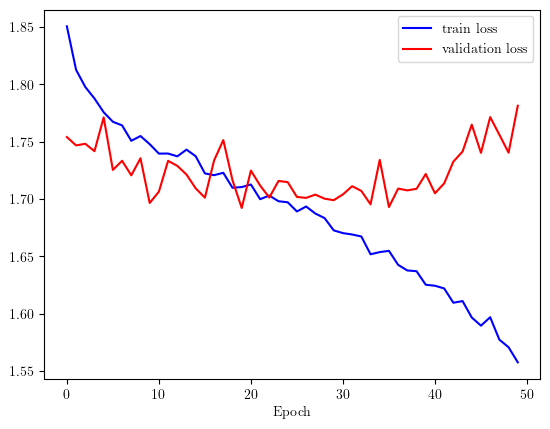

In [12]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

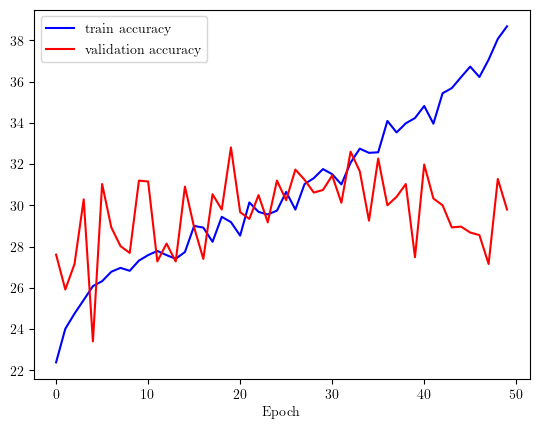

In [13]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

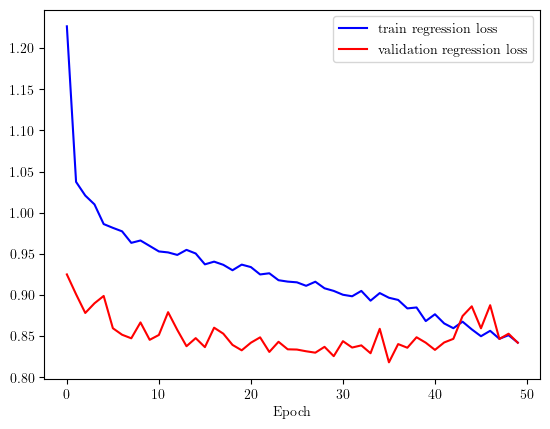

In [14]:
# Regression loss
train_regression_losses = regression_loss_values[0]
val_regression_losses = regression_loss_values[1]

plt.plot(train_regression_losses, "b", label="train regression loss")
plt.plot(val_regression_losses, "r", label="validation regression loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

#### Testing the model

In [15]:
# Set the uncertainty function
uncertainty_function = uncertainty.functions.shannon_entropy

# Test the model
_, test_accuracy, test_regression_loss, test_regression_losses, uncertainties = test(model,
                                                                                     device,
                                                                                     test_loader,
                                                                                     criterion_classification,
                                                                                     criterion_regression,
                                                                                     bins_midpoints,
                                                                                     uncertainty_function)

print("Test accuracy: ", test_accuracy)
print("Regression loss: ", test_regression_loss)

Test accuracy:  27.858027238959966
Regression loss:  0.8623643246920485


## Save model parameters

In [16]:
# Save the model parameters
# torch.save(model.state_dict(), "multimodal_velocity.params")

## Assessing the relevance of the uncertainty

In [17]:
# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty =\
    uncertainty.evaluation.uncertainty_relevance(
        model,
        device,
        criterion_classification,
        criterion_regression,
        bins_midpoints,
        uncertainty_function,
        test,
        test_set,
        test_regression_loss,
        test_regression_losses,
        uncertainties)

#### Plotting the results

Text(0, 0.5, 'Regression error (MSE)')

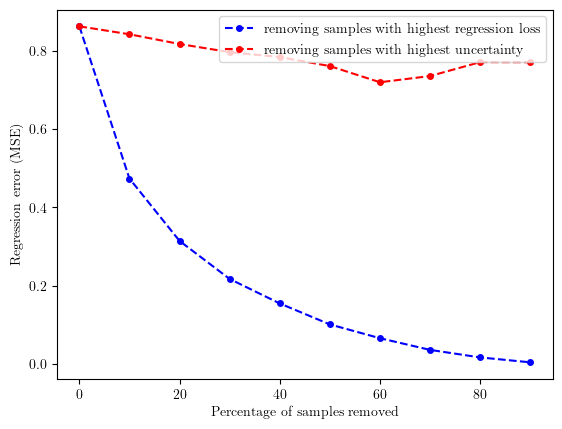

In [18]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")

### Ensemble learning

#### Training the models

In [ ]:
# Create a list of models
nb_models = 3
some_models = [ResNet18Velocity().to(device=device) for _ in range(nb_models)]

# Loop over the models
for i in range(nb_models):
    
    print(f"Training model {i+1}/{nb_models}")
    
    # Get all the parameters excepts the weights and bias of fc layer
    base_params = [param for name, param in some_models[i].named_parameters()
                   if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

    # Define the optimizer, with a greater learning rate for the new fc layer
    optimizer = optim.SGD([
        {"params": base_params},
        {"params": some_models[i].resnet18.fc.parameters(),
         "lr": LEARNING_PARAMS["learning_rate"] * 10},
    ],
        lr=LEARNING_PARAMS["learning_rate"],
        momentum=LEARNING_PARAMS["momentum"],
        weight_decay=LEARNING_PARAMS["weight_decay"])
    
    # Loop over the epochs
    for epoch in range(LEARNING_PARAMS["nb_epochs"]):

        # Train the model
        train_loss, train_accuracy, train_regression_loss = train(some_models[i],
                                                                  device,
                                                                  train_loader,
                                                                  optimizer,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  epoch)

Training model 1/3


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/354 [00:00<?, ?batch/s]

Training model 2/3


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/354 [00:00<?, ?batch/s]

Training model 3/3


  0%|          | 0/354 [00:00<?, ?batch/s]

  0%|          | 0/354 [00:00<?, ?batch/s]

In [ ]:
# Create arrays to store the test losses
# test_losses_loss = np.zeros((nb_models, 10))
# test_losses_uncertainty = np.zeros((nb_models, 10))

uncertainty_function = uncertainty.functions.shannon_entropy

# Test the models
test_regression_loss, test_regression_losses, uncertainties = test_models(some_models,
                                                                          device,
                                                                          test_loader,
                                                                          criterion_classification,
                                                                          criterion_regression,
                                                                          bins_midpoints,
                                                                          uncertainty_function)
print("Test regression loss: ", test_regression_loss)

# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = \
    uncertainty.evaluation.uncertainty_relevance_models(some_models,
                                                        device,
                                                        criterion_classification,
                                                        criterion_regression,
                                                        bins_midpoints,
                                                        uncertainty_function,
                                                        test_models,
                                                        test_set,
                                                        test_regression_loss,
                                                        test_regression_losses,
                                                        uncertainties)

Test regression loss:  0.8872574639585614


#### Plotting the results

Text(0, 0.5, 'Regression error (MSE)')

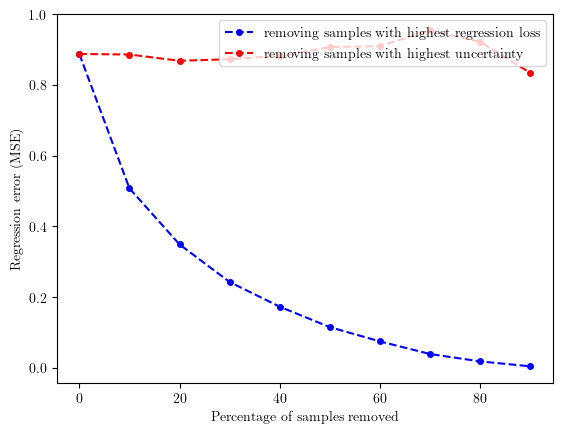

In [ ]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")